In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../"))

# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.25"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
# os.environ["XLA_FLAGS"] = (
#     "--xla_disable_hlo_passes=constant_folding",  # this disables constant folding
#     "--xla_cpu_use_thunk_runtime=false",
# )
from desc import set_device
set_device("gpu")

In [2]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [3]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic
from desc.compute.data_index import register_compute_fun
from desc.optimize.utils import solve_triangular_regularized

print_backend_info()

DESC version=0.16.0+431.g27a83e1ba.
Using JAX backend: jax version=0.6.2, jaxlib version=0.6.2, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 11.58 GB available memory.


In [4]:
def set_poincare_equilibrium(eq, ensure_nested=True):
    eq_poincare = Equilibrium(
        xsection=eq.get_surface_at(zeta=0),
        pressure=eq.pressure,
        iota=eq.iota,
        Psi=eq.Psi,  # flux (in Webers) within the last closed flux surface
        NFP=eq.NFP,  # number of field periods
        L=eq.L,  # radial spectral resolution
        M=eq.M,  # poloidal spectral resolution
        N=eq.N,  # toroidal spectral resolution
        L_grid=eq.L_grid,  # real space radial resolution, slightly oversampled
        M_grid=eq.M_grid,  # real space poloidal resolution, slightly oversampled
        N_grid=eq.N_grid,  # real space toroidal resolution
        sym=eq.sym,  # explicitly enforce stellarator symmetry
        spectral_indexing=eq._spectral_indexing,
        ensure_nested=ensure_nested,
    )

    eq_poincare.change_resolution(eq.L, eq.M, eq.N)
    eq_poincare.axis = eq_poincare.get_axis()
    eq_poincare.surface = eq_poincare.get_surface_at(rho=1)
    return eq_poincare

In [5]:
eq = get("NCSX")

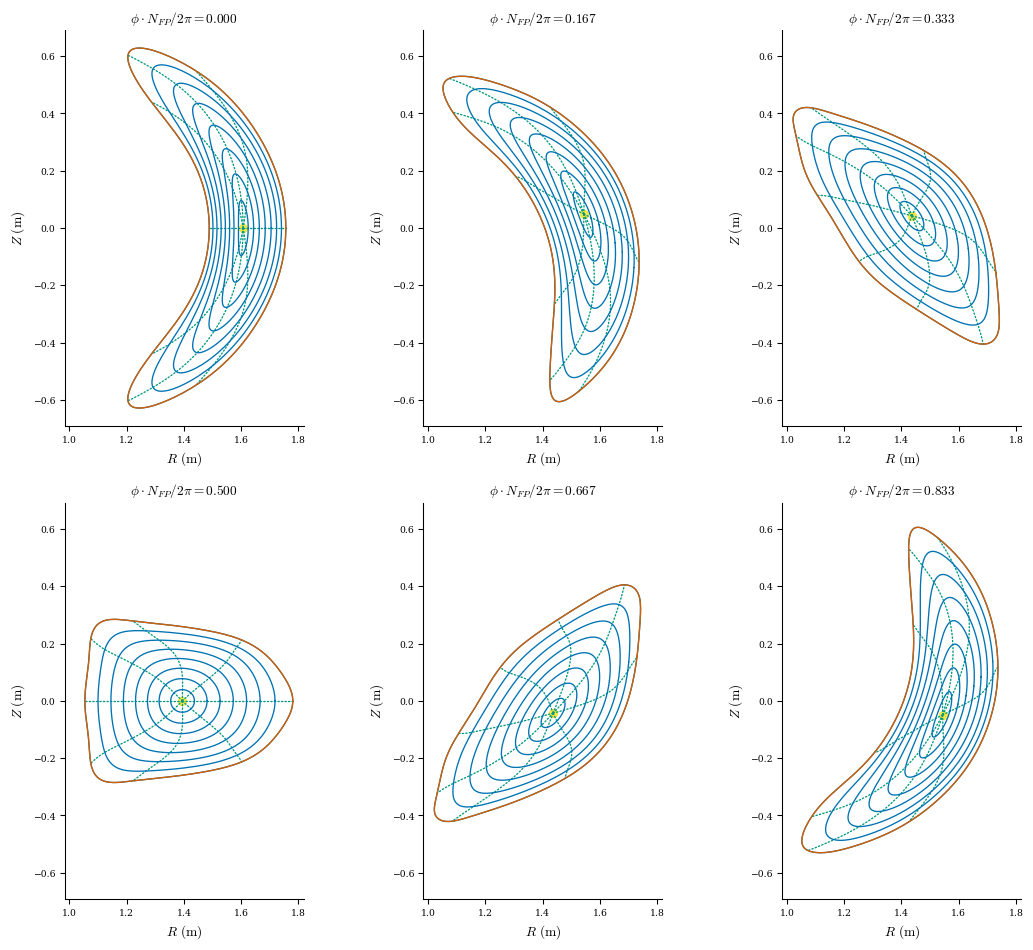

In [6]:
plot_surfaces(eq);

# Zernike Coeffcients for Poincare Cross-section can create self-intersecting surfaces!

We will change the high mode coefficients to a relatively large value to create self-intersection.

In [7]:
eq1 = eq.copy()
eq1.R_lmn[eq.R_basis.modes[:, 0] == 10] = 0.01

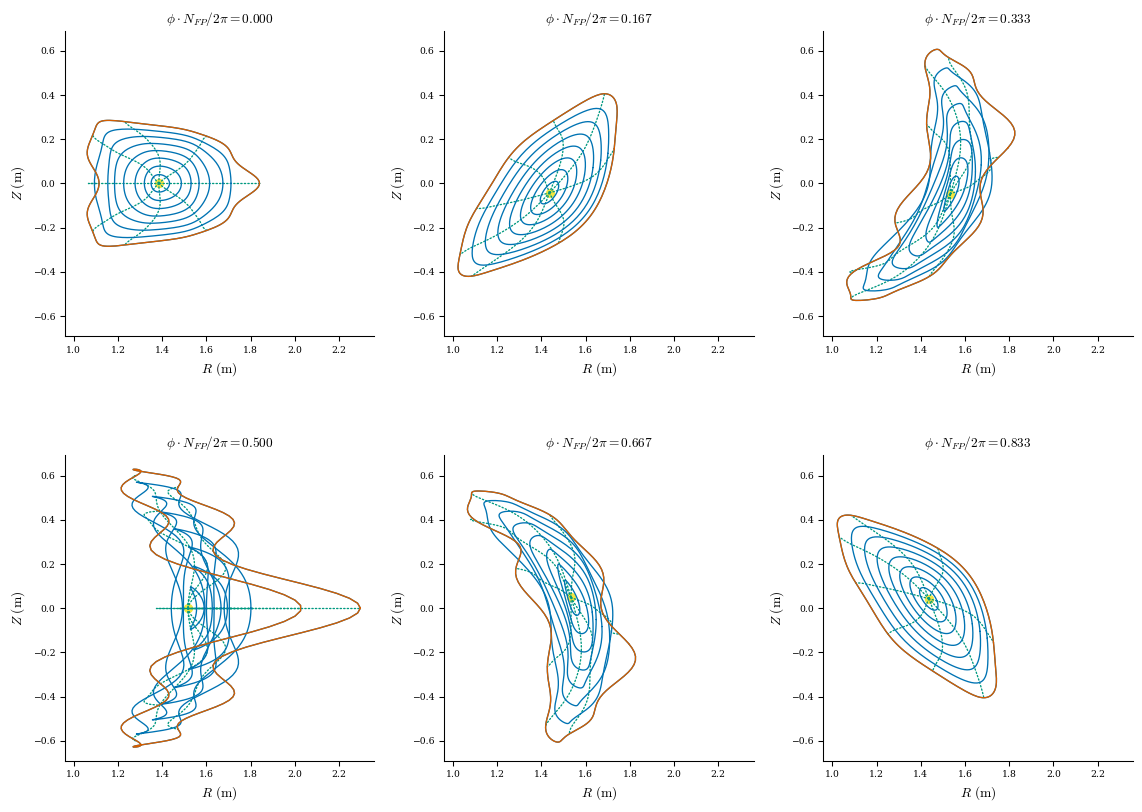

In [26]:
eq1_rotated = rotate_zeta(eq1, angle=np.pi / eq.NFP, copy=True)
plot_surfaces(eq1_rotated);

Nothing is limiting the self-intersection of surfaces when you use Poincare representation.

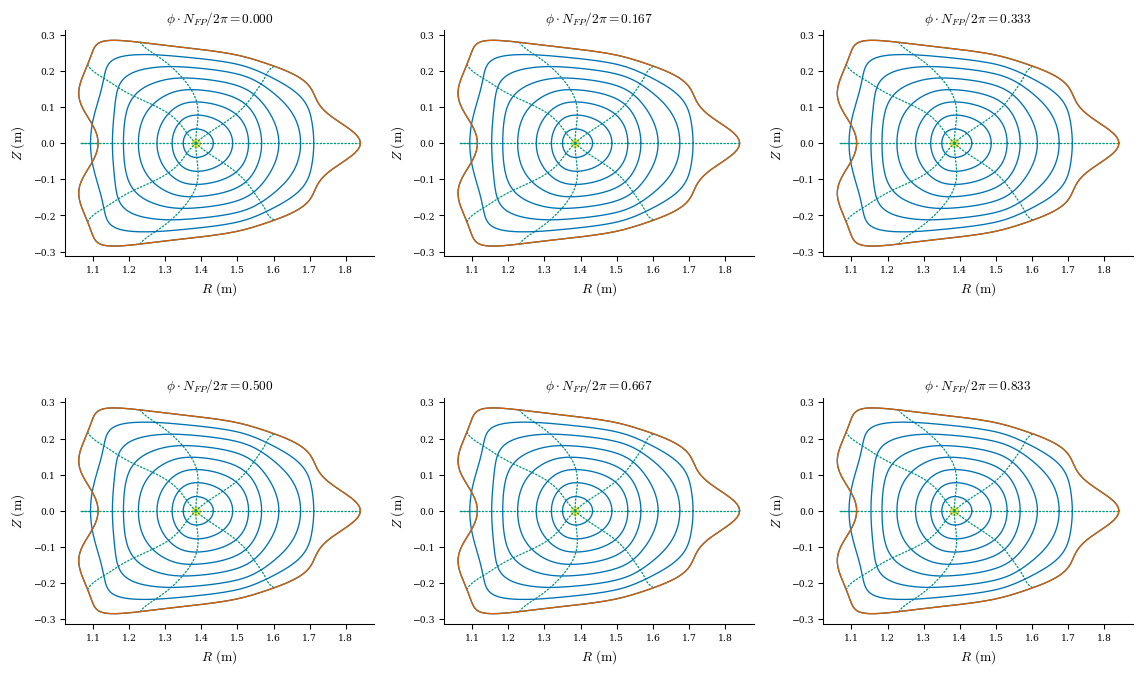

In [27]:
eq1p = set_poincare_equilibrium(eq1_rotated, ensure_nested=False)
plot_surfaces(eq1p);

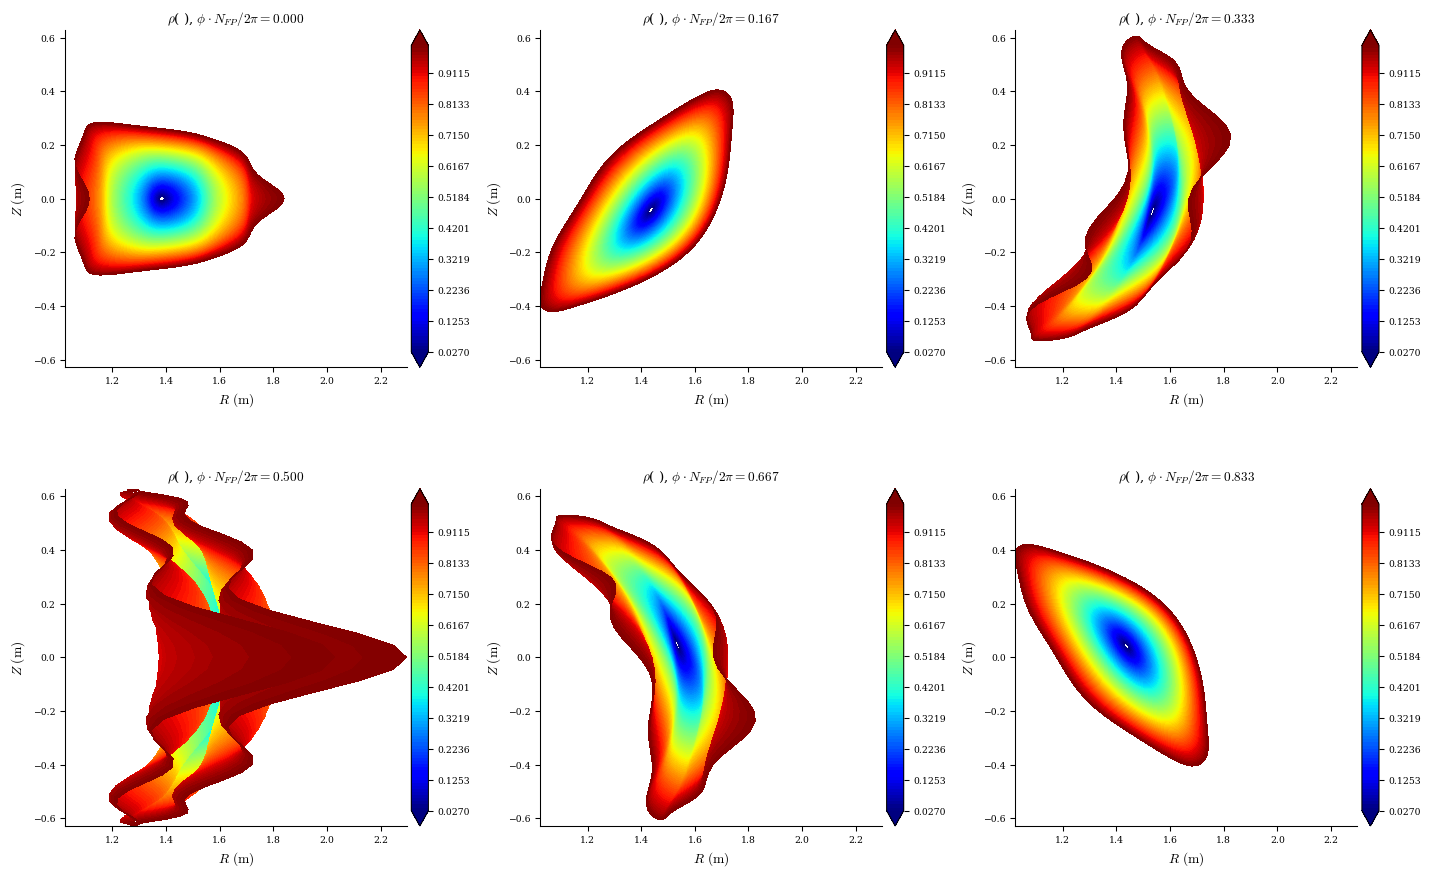

In [29]:
plot_section(eq1_rotated, "rho");

# Closeness in phase-space

In [205]:
surf = FourierRZToroidalSurface(
    R_lmn=[1, 0.2],
    Z_lmn=[-0.2],
    modes_R=[[0, 0], [1, 0]],
    modes_Z=[[-1, 0]],
    NFP=20,
)
# default is zero pressure and zero current
eq = Equilibrium(M=32, N=0, Psi=0.087, surface=surf)

In [206]:
npoints = 20
grid1 = LinearGrid(rho=1, theta=npoints, sym=False, NFP=1)
data1 = eq.compute(["R", "Z", "theta"], grid=grid1)

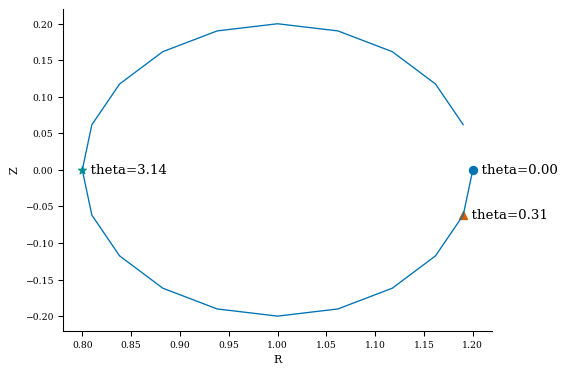

In [207]:
data = data1
plt.plot(data["R"], data["Z"])
plt.scatter(x=data["R"][0], y=data["Z"][0], marker="o")
plt.scatter(x=data["R"][1], y=data["Z"][1], marker="^")
plt.scatter(
    x=data["R"][len(data["R"]) // 2], y=data["Z"][len(data["R"]) // 2], marker="*"
)
plt.text(
    data["R"][0],
    data["Z"][0],
    f"  theta={data["theta"][0]:.2f}",
    fontsize=10,
    va="center",
)
plt.text(
    data["R"][1],
    data["Z"][1],
    f"  theta={data["theta"][1]:.2f}",
    fontsize=10,
    va="center",
)
plt.text(
    data["R"][len(data["R"]) // 2],
    data["Z"][len(data["R"]) // 2],
    f"  theta={np.pi:.2f}",
    fontsize=10,
    va="center",
)
plt.xlabel('R')
plt.ylabel('Z')
plt.show()

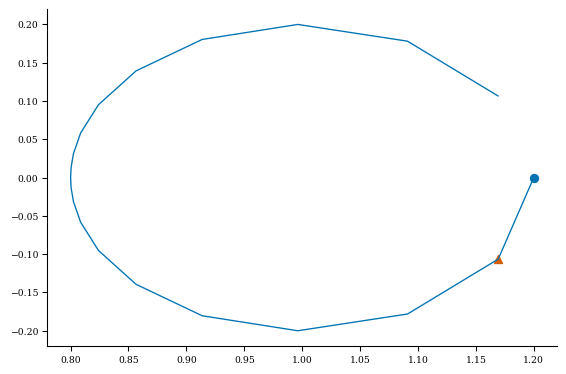

In [208]:
theta = np.linspace(0, np.pi * 2, npoints, endpoint=False)
theta_new = theta + 0.8 * np.sin(theta)
R = 1 + 0.2 * np.cos(theta_new)
Z = -0.2 * np.sin(theta_new)
plt.plot(R, Z)
plt.scatter(x=R[0], y=Z[0], marker="o")
plt.scatter(x=R[1], y=Z[1], marker="^");

Text(0.5, 1.0, 'New theta vs Old theta')

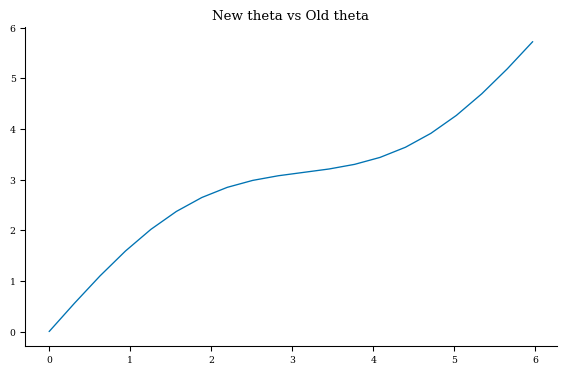

In [209]:
plt.plot(theta, theta_new)
plt.title("New theta vs Old theta")

In [210]:
grid2 = LinearGrid(rho=1, theta=theta_new, sym=False, NFP=1)
data2 = eq.compute(["R", "Z", "theta"], grid=grid2)

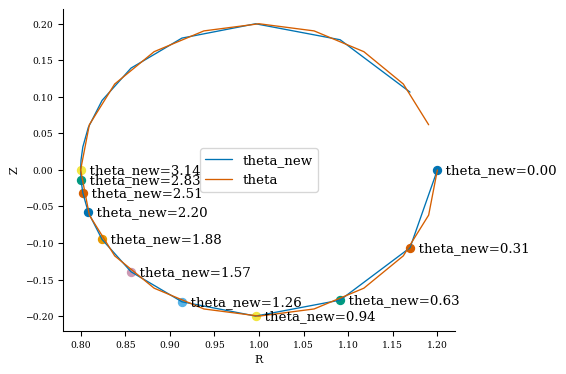

In [211]:
data = data2
plt.plot(data["R"], data["Z"], label="theta_new")
plt.plot(data1["R"], data1["Z"], label="theta")
for i in range(len(data["R"])//2 + 1):
    plt.scatter(x=data["R"][i], y=data["Z"][i], marker="o")
    plt.text(
        data["R"][i],
        data["Z"][i],
        f"  theta_new={theta[i]:.2f}",
        fontsize=10,
        va="center",
    )
plt.xlabel("R")
plt.ylabel("Z")
plt.legend()

# Do stuff with DSHAPE

In [222]:
eq = get("DSHAPE")

In [ ]:
theta_grid = np.linspace(0, np.pi * 2, 256, endpoint=False)
theta_new_grid = theta_grid + 0.5 * np.sin(theta_grid)
grid3 = LinearGrid(rho=1, theta=theta_new_grid, sym=False, NFP=eq.NFP)
data3 = eq.compute(["x", "R", "Z", "theta"], grid=grid3)
# here by giving the theta_grid grid, we change the theta definition
# the points that had theta_grid_new now becomes theta_grid
surf_new = FourierRZToroidalSurface.from_values(data3["x"], theta=theta_grid, M=eq.M, N=0, NFP=eq.NFP)
eq_new0 = Equilibrium(
    surface=surf_new,
    pressure=eq.pressure,
    iota=eq.iota,
    Psi=eq.Psi,  # flux (in Webers) within the last closed flux surface
    NFP=eq.NFP,  # number of field periods
    L=eq.L,  # radial spectral resolution
    M=eq.M,  # poloidal spectral resolution
    N=eq.N,  # toroidal spectral resolution
    L_grid=eq.L_grid,  # real space radial resolution, slightly oversampled
    M_grid=eq.M_grid,  # real space poloidal resolution, slightly oversampled
    N_grid=eq.N_grid,  # real space toroidal resolution
    sym=eq.sym,  # explicitly enforce stellarator symmetry
    spectral_indexing=eq._spectral_indexing,
    ensure_nested=False,
)
eq_new = eq_new0.copy()
eq_new.solve(maxiter=1000, ftol=1e-3, gtol=0, xtol=1e-8, verbose=3);

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 758 ms
Timer: Objective build = 1.08 sec
Building objective: fixed LCFS R
Building objective: fixed LCFS Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed sheet current
Building objective: self_consistency lcfs R
Building objective: self_consistency lcfs Z
Building objective: lambda gauge
Building objective: self_consistency axis R
Building objective: self_consistency axis Z
Timer: Objective build = 505 ms
Timer: LinearConstraintProjection build = 4.92 sec
Number of parameters: 260
Number of objectives: 756
Timer: Initializing the optimization = 6.60 sec

Starting optimization
Using method: lsq-exact
Solver options:
------------------------------------------------------------
Maximum Function Evaluations       : 5001
Maximum Allowed Total Δx Norm      : inf
Scaled Termination                 : True
Trust Region Method              

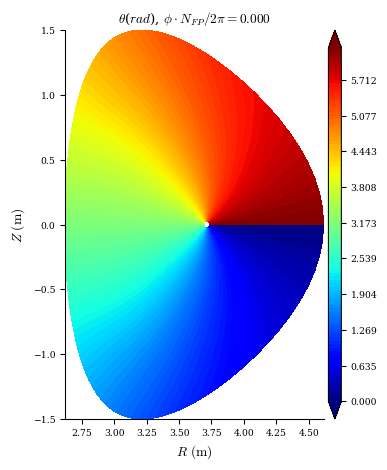

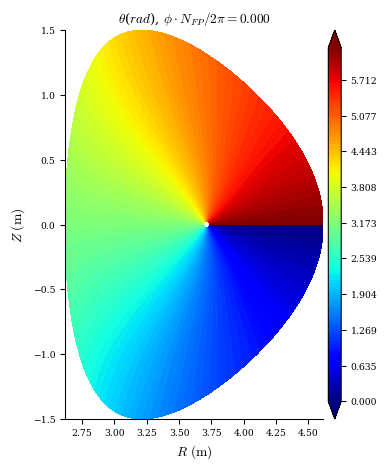

In [225]:
plot_section(eq_new, "theta")
plot_section(eq, "theta");

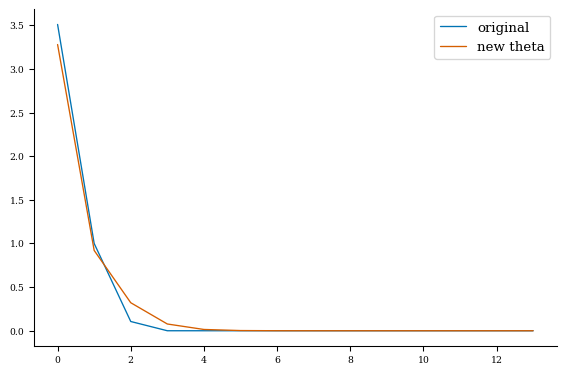

In [226]:
plt.plot(eq.Rb_lmn, label="original")
plt.plot(eq_new.Rb_lmn, label="new theta")
plt.legend();

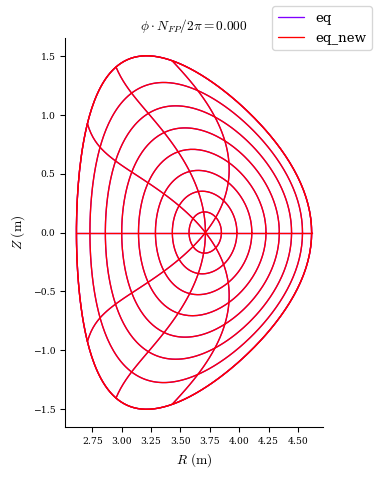

In [227]:
plot_comparison([eq, eq_new], labels=["eq", "eq_new"]);

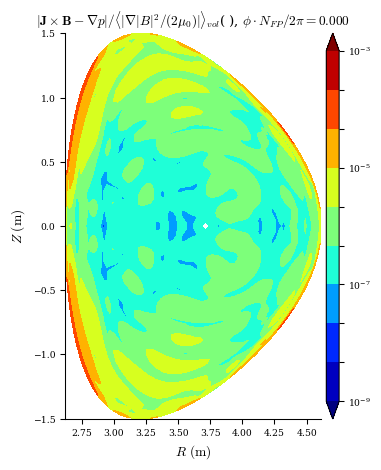

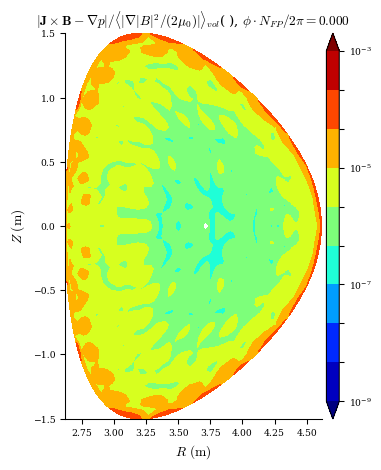

In [244]:
levels = np.logspace(-9, -3, 10)
plot_section(eq, "|F|_normalized", log=True, levels=levels)
plot_section(eq_new, "|F|_normalized", log=True, levels=levels);

In [230]:
eq.xsection = eq.get_surface_at(zeta=0)
eq_new.xsection = eq_new.get_surface_at(zeta=0)

In [233]:
def get_normalized_dot(x, y):
    return jnp.dot(x, y) / (jnp.linalg.norm(x) * jnp.linalg.norm(y))

In [236]:
get_normalized_dot(eq.Rp_lmn, eq_new.Rp_lmn), get_normalized_dot(
    eq.Rb_lmn, eq_new.Rb_lmn
)

(Array(0.9973, dtype=float64), Array(0.9976, dtype=float64))

In [237]:
get_normalized_dot(eq.Zp_lmn, eq_new.Zp_lmn), get_normalized_dot(
    eq.Zb_lmn, eq_new.Zb_lmn
)

(Array(0.9698, dtype=float64), Array(0.9618, dtype=float64))

In [238]:
p0_state = jnp.concatenate([eq.Rp_lmn, eq.Zp_lmn, eq.Lp_lmn])
p1_state = jnp.concatenate([eq_new.Rp_lmn, eq_new.Zp_lmn, eq_new.Lp_lmn])
get_normalized_dot(p0_state, p1_state)

Array(0.9854, dtype=float64)

In [240]:
s0_state = jnp.concatenate([eq.Rb_lmn, eq.Zb_lmn])
s1_state = jnp.concatenate([eq_new.Rb_lmn, eq_new.Zb_lmn])
get_normalized_dot(s0_state, s1_state)

Array(0.9924, dtype=float64)